In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=e60fac7451437f43db78352072f2bb4697496280cc950d1913bf8ee3d63305ff
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# df = spark.read.csv('/content/drive/MyDrive/dataset/Airplane/Airplane_Crashes_and_Fatalities_Since_1908.csv', header=True)

In [4]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=54c873b6a0a8599c1bf39e76b9c722d1f1450bd5b3b74342d5a9dcfdeafc6115
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn


In [5]:
# Import PySpark modules
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.sql.functions import regexp_replace
from pyspark.ml.clustering import KMeans

# Initialize SparkSession
spark = SparkSession.builder.appName("FlightAccidentStopWordsRemoval").getOrCreate()

# Load data from CSV file
data = spark.read.csv("/content/drive/MyDrive/Airplane_Crashes_and_Fatalities_Since_1908.csv", header=True, inferSchema=True)

data = data.na.drop(subset=['Summary'])

data = data.withColumn("Summary", regexp_replace(data["Summary"], "[\.,]", ""))

# Tokenize the "Summary" column
tokenizer = Tokenizer(inputCol="Summary", outputCol="tokens")
data = tokenizer.transform(data)

# Remove stop words from the tokens
stopwords = StopWordsRemover.loadDefaultStopWords("english")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=stopwords)
data = stopwords_remover.transform(data)

# Show the result after stop words removal
# data.select("Summary", "filtered_tokens").show(truncate=False)

In [6]:
# data.printSchema()


In [7]:
data.count()


4878

In [8]:
# Gabungkan hasil token-token menjadi satu
teks = [row[0] for row in data.select("filtered_tokens").collect()]

teks_gabung = [' '.join(dokumen) for dokumen in teks]

# print(teks_gabung)


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Membuat objek TfidfVectorizer
vectorizer = TfidfVectorizer()

# Menghitung nilai TF-IDF
tfidf_matrix = vectorizer.fit_transform(teks_gabung)

# Mendapatkan daftar fitur
feature_names = vectorizer.get_feature_names_out()
# Menampilkan hasil TF-IDF
# top_k = 3
# for i, row in enumerate(tfidf_matrix.toarray()):
#     print("Dokumen", i+1)
#     top_indices = np.argsort(row)[::-1][:top_k]
#     for index in top_indices:
#         print(feature_names[index])
#     print()


In [10]:
from sklearn.model_selection import train_test_split
label_teks = np.array(data.select('Summary').collect()).flatten()
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, label_teks, test_size=0.2, random_state=42)

## Menggunakan Model Support Vector Classifier

In [11]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# param_grid = {'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}
# grid_search = GridSearchCV(SVC(), param_grid, cv=5)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_

In [12]:
from sklearn.svm import SVC
# model = SVC(**best_params)
model = SVC()

In [13]:
model.fit(X_train, y_train)

SVC()

In [14]:
y_pred = model.predict(X_test)

In [15]:
print(y_pred)

['Crashed while en route' 'Crashed while attempting to land'
 'Flew into a mountain' 'Crashed short of the runway'
 'Crashed short of the runway' 'Shot down by Afghan rebels'
 'Engine failure' 'Crashed on approach' 'Shot down by British aircraft'
 'Crashed while taking off' 'Shot down by rebels'
 'Crashed shortly after taking off' 'Crashed short of the runway'
 'Crashed shortly after taking off' 'Crashed into a village'
 'Crashed while attempting to land' 'Weather related'
 'Crashed while attempting to land' 'Crashed shortly after taking off'
 'Crashed while taking off' 'The cargo plane crashed' 'Midair collision'
 'The cargo plane crashed' 'Shot down by enemy fire'
 'Crashed into a mountain' 'Crashed on approach' 'Crashed while landing'
 'Crashed into a mountain' 'Crashed into mountains'
 'Crashed into the sea Most probably the captain suffered a heart attack and the first officer could not regain control of aircraft'
 'Crashed shortly after taking off' 'Crashed after running out of f

In [16]:
# print(y_pred.shape[0])

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.035860655737704916
Precision: 0.009612761466841015
Recall: 0.035860655737704916
F1-score: 0.01232700096797655


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
import pandas as pd

# Membuat dataframe dari X_test
df_X_test = pd.DataFrame(X_test.toarray(), columns=feature_names)

# Membuat dataframe dari y_pred
df_y_pred = pd.DataFrame({'Prediksi': y_pred})

# Menggabungkan dataframe X_test dan y_pred
df_hasil_prediksi = pd.concat([df_X_test, df_y_pred], axis=1)

# Menampilkan dataframe hasil prediksi
print(df_y_pred)

                                       Prediksi
0                        Crashed while en route
1              Crashed while attempting to land
2                          Flew into a mountain
3                   Crashed short of the runway
4                   Crashed short of the runway
..                                          ...
971                    Crashed while taking off
972                       Crashed while landing
973                         Shot down by rebels
974  Crashed into a mountainside in a snowstorm
975               Crashed shortly after takeoff

[976 rows x 1 columns]


In [19]:
import random
import pandas as pd

# Bobot dan kelas
kelas = {
    "Kecelakaan Helikopter akibat Serangan Pemberontak": {'helicopter': 0.013, 'rebels': 0.008, 'crashed': 0.006, 'shot': 0.006, 'rotor': 0.006},
    "Kecelakaan Pesawat segera setelah Lelepas Landas": {'crashed': 0.009, 'plane': 0.009, 'aircraft': 0.007, 'taking': 0.007, 'shortly': 0.007},
    "Kecelakaan Pesawat saat Lepas Landas di Daerah Berbukit atau Akibat Cuaca": {'crashed': 0.016, 'takeoff': 0.011, 'mountain': 0.009, 'poor': 0.007, 'weather': 0.006},
    "Kecelakaan Pesawat saat Pendekatan Landasan atau Mendarat": {'approach': 0.015, 'plane': 0.015, 'crashed': 0.013, 'cargo': 0.012, 'runway': 0.011},
    "Kecelakaan Pesawat di Rute Penerbangan": {'route': 0.018, 'en': 0.018, 'crashed': 0.014, 'plane': 0.010, 'cargo': 0.006},
    "Kecelakaan Pesawat saat Penerbangan": {'crashed': 0.012, 'plane': 0.011, 'aircraft': 0.008, 'flight': 0.006, 'taking': 0.005},
    "Kecelakaan Pesawat saat Mendarat atau Lepas Landas": {'plane': 0.009, 'crashed': 0.009, 'landing': 0.009, 'pilot': 0.008, 'aircraft': 0.008},
    "Kecelakaan Pesawat saat dalam Penerbangan (Masalah Internal)": {'crashed': 0.009, 'flight': 0.009, 'pilot': 0.008, 'plane': 0.008, 'aircraft': 0.008},
    "Kecelakaan Pesawat akibat Mengambil atau Mendarat di Daerah Pegunungan": {'crashed': 0.010, 'mountain': 0.009, 'taking': 0.009, 'aircraft': 0.008, 'plane': 0.008}
}

# Mengakses kolom 'kalimat' dari DataFrame
kalimat_array = y_pred

# Inisialisasi list untuk menyimpan hasil prediksi
prediksi_kelas = []

for i in kalimat_array:
    # Inisialisasi nilai tertinggi dan kelas tujuan
    nilai_tertinggi = -1
    kelas_tujuan = None

    # Melakukan perhitungan nilai untuk setiap kelas
    for kelas_id, bobot_kata in kelas.items():
        nilai = 0
        for kata, bobot in bobot_kata.items():
            jumlah_kata = i.count(kata)
            nilai += bobot * jumlah_kata

        # Memperbarui nilai tertinggi dan kelas tujuan jika ditemukan nilai yang lebih tinggi
        if nilai > nilai_tertinggi:
            nilai_tertinggi = nilai
            kelas_tujuan = kelas_id
        elif nilai == nilai_tertinggi:
            # Jika terdapat nilai yang sama, pilih secara acak
            if random.random() < 0.5:
                kelas_tujuan = kelas_id

    # Menambahkan kelas tujuan ke dalam list hasil prediksi
    prediksi_kelas.append(kelas_tujuan)

    # Menampilkan hasil prediksi untuk setiap kalimat
    # print("Kalimat:", i)
    # print("Prediksi Kelas:", kelas_tujuan)
    # print("----------")

# Membuat kolom baru 'prediksi_kelas' dalam DataFrame dan mengisinya dengan hasil prediksi
df_prediksi = prediksi_kelas




In [20]:
# Dataframe pertama
# df1 = pd.DataFrame({'Kalimat': y_pred})

# DataFrame kedua
# df2 = pd.DataFrame({'Kelas': df_prediksi})

# print(df2)

# # Menggabungkan kedua dataframe
# df_gabungan = pd.concat([df1, df2], axis=1)

# # Menampilkan dataframe gabungan
# print(df_gabungan)

In [21]:
import pandas as pd

# Contoh dataframe pertama
df1 = pd.DataFrame({'Kalimat' : y_pred})

# Contoh dataframe kedua
df2 = pd.DataFrame({'Prediksinya': df_prediksi})

# Membuat Series dari list
series_kalimat = pd.Series(y_pred)
series_prediksi = pd.Series(df_prediksi)

# Menggabungkan kedua Series menjadi DataFrame
df_gabungan = pd.concat([series_kalimat, series_prediksi], axis=1)
# Menggabungkan kedua dataframe
df_gabungan = pd.concat([series_kalimat, series_prediksi], axis=1)

# Menampilkan dataframe gabungan
print(df_gabungan)


                                              0  \
0                        Crashed while en route   
1              Crashed while attempting to land   
2                          Flew into a mountain   
3                   Crashed short of the runway   
4                   Crashed short of the runway   
..                                          ...   
971                    Crashed while taking off   
972                       Crashed while landing   
973                         Shot down by rebels   
974  Crashed into a mountainside in a snowstorm   
975               Crashed shortly after takeoff   

                                                     1  
0               Kecelakaan Pesawat di Rute Penerbangan  
1    Kecelakaan Pesawat akibat Mengambil atau Menda...  
2    Kecelakaan Pesawat akibat Mengambil atau Menda...  
3    Kecelakaan Pesawat saat Pendekatan Landasan at...  
4    Kecelakaan Pesawat saat Pendekatan Landasan at...  
..                                           

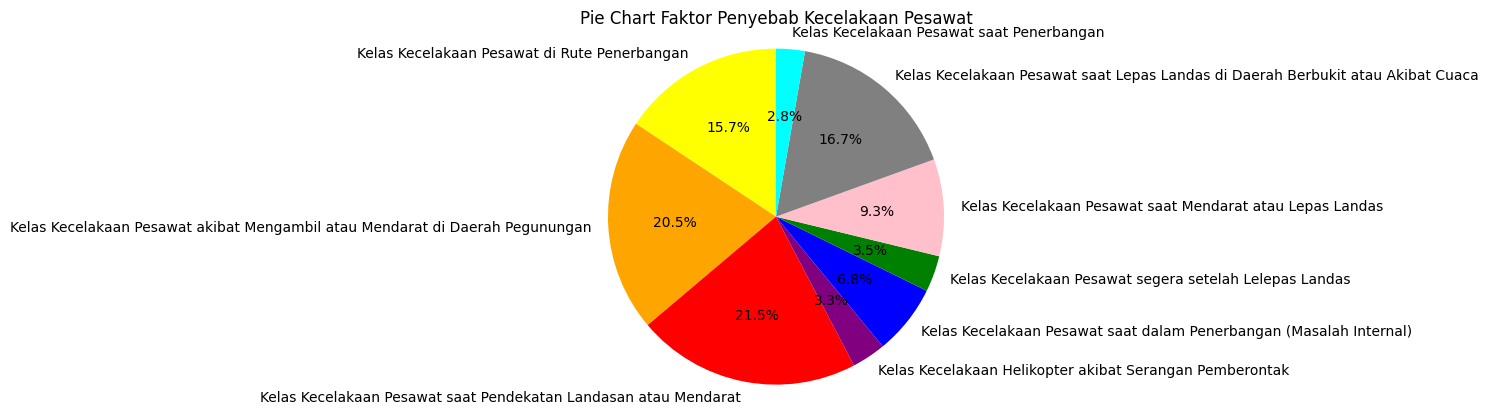

In [22]:
import matplotlib.pyplot as plt

# Hasil kelas tujuan
kelas_tujuan = df_prediksi

# Menghitung jumlah kemunculan setiap kelas tujuan
kelas_count = {}
for kelas in kelas_tujuan:
    if kelas in kelas_count:
        kelas_count[kelas] += 1
    else:
        kelas_count[kelas] = 1

# Menyiapkan label dan data untuk pie chart
labels = []
sizes = []
for kelas, count in kelas_count.items():
    labels.append(f'Kelas {kelas}')
    sizes.append(count)

# Menentukan warna untuk setiap bagian pie chart
colors = ['yellow', 'orange', 'red', 'purple', 'blue', 'green', 'pink', 'gray', 'cyan']

# Membuat pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Menampilkan legend dan judul
plt.title('Pie Chart Faktor Penyebab Kecelakaan Pesawat')

# Menampilkan pie chart
plt.axis('equal')
plt.show()


In [23]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)


> Link Google Collab : https://colab.research.google.com/drive/1Z28ET6wAy5jjRafbxDpQpZg0xqRUDS-Q?usp=sharing

